### Задание

Создайте нейронную сеть, распознающую рукописные цифры. Используя подготовленную базу и шаблон ноутбука, нормируйте данные, создайте и обучите сверточную сеть.

**Параметры модели:** сеть должна содержать минимум 2 сверточных слоя; полносвязные слои; слои подвыборки, нормализации, регуляризации по 1 шт.

**Гиперпараметры обучения:** функция ошибки - категориальная кроссэнтропия, оптимизатор - Adam с шагом обучения одна тысячная, размер батча - 128, количество эпох 15, детали обучения - отображать.

**В конце** выведите график обучения: доли верных ответов на обучающей и проверочной выборках.


In [ ]:
# загрузка датасета MNIST

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Утилиты для to_categorical()
from tensorflow.keras import utils

# Подключение библиотеки для генерации случайных чисел
import random

# Подключение класса для работы с изображением
from PIL import Image

# Рисование графиков в ячейках Colab
%matplotlib inline

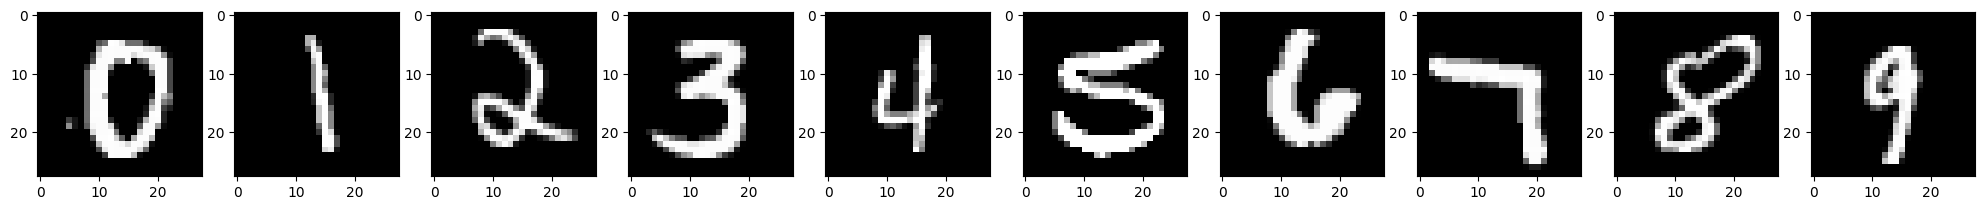

In [ ]:
# вывод изображений каждого класса для ознакомления с датасетом

fig, axs = plt.subplots(1, 10, figsize=(25,3)) # создаем полотно для 10 графиков с размером 25 на 3
for i in range(10):
  label_indexes = np.where(y_train == i)[0] # получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) # выбирает случайный индекс из списка созданного выше
  img = x_train[index] # выбираем из x_train нужное положение
  axs[i].imshow(Image.fromarray(img), cmap='gray') # выводим изображение

plt.show()

In [ ]:
# добавляем размерность массиву mnist, чтобы сеть поняла что это чб
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# преобразуем выборки с ответами в OHE
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

# посмотрим форматы выборок перед обучением
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)
print()
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)

y_train: (60000, 10)
y_test: (10000, 10)


## **Нормализация данных**

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## **Сервисные функции**

In [ ]:
def compile_train_model(model,                  # модель нейронной сети
                        x_train,             # обучающие данные
                        y_train,
                        optimizer=Adam(0.0001),    # оптимизатор
                        epochs=15,          # количество эпох обучения
                        batch_size=128,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split = 0.2,
                        verbose=1,
                        shuffle=True)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода результатов оценки модели на заданных данных

def eval_model(model,
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             x_train,
                             y_train,                  # обучающие данные
                             x_test,
                             y_test,                   # тестовые данные
                             class_labels=y_train,  # список меток классов
                             title='',                 # название модели
                             optimizer=Adam(0.0001),      # оптимизатор
                             epochs=15,            # количество эпох обучения
                             batch_size=128,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train,
                        y_train,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

## **Создание нейронной сети**

Параметры модели: сеть должна содержать минимум 2 сверточных слоя; полносвязные слои; слои подвыборки, нормализации, регуляризации по 1 шт.

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))  # (28,28,1) --> (28,28,256) меняется кол-во фильтров
model.add(BatchNormalization())  # (64,128,256) --> (64,128,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))  # (28,28,256) --> (28,28,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3)))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (28,28,256) --> (9,9,256)

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))  # (9,9,256) --> (9,9,256) нет изменений
model.add(Dropout(0.2))  # (21,42,256) --> (21,42,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3)))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (9,9,256) --> (3,3,256)
model.add(Dropout(0.2))  # (7,14,256) --> (7,14,256) нет изменений

# Пятый сверточный блок
#model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (7,14,256) --> (7,14,512) меняется количество фильтров
#model.add(BatchNormalization(name='Fifth_B'))  # (7,14,512) --> (7,14,512) нет изменений

# Шестой сверточный блок
#model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (7,14,1024) --> (7,14,1024) меняется кол-во фильтров
#model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (7,14,1024) --> (2,4,1024)
#model.add(Dropout(0.2, name='Sixth_D'))  # (2,4,1024) --> (2,4,1024) нет изменений

# Блок классификации
model.add(Flatten())  # слой преобразования многомерных данных в одномерные (9,9,256) --> (2*4*1024) --> (8192)
model.add(Dense(1024, activation='relu'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(2048, activation='relu'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(10, activation='softmax'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (3)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 256)       1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 256)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 256)         590080    
                                                                 
 dropout (Dropout)           (None, 9, 9, 256)         0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 256)       2560      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 256)       1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       590080    
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 256)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 256)         590080    
                                                                 
 dropout (Dropout)           (None, 9, 9, 256)         0

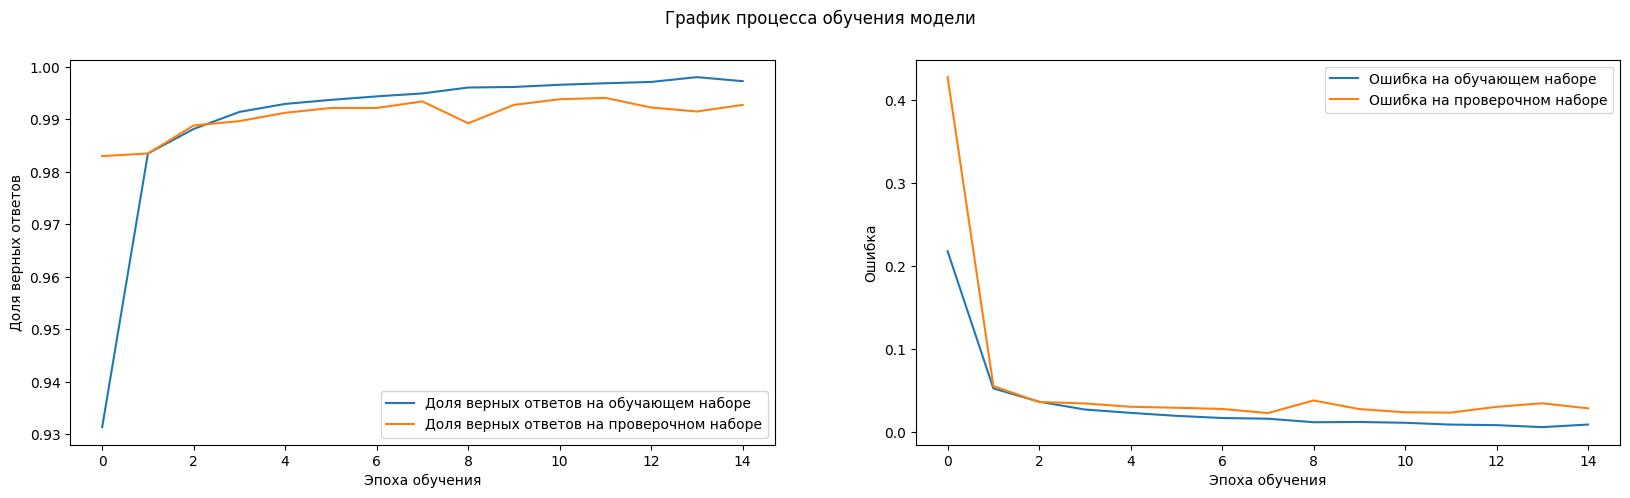

313/313 [==============================] - 3s 7ms/step


TypeError: ignored

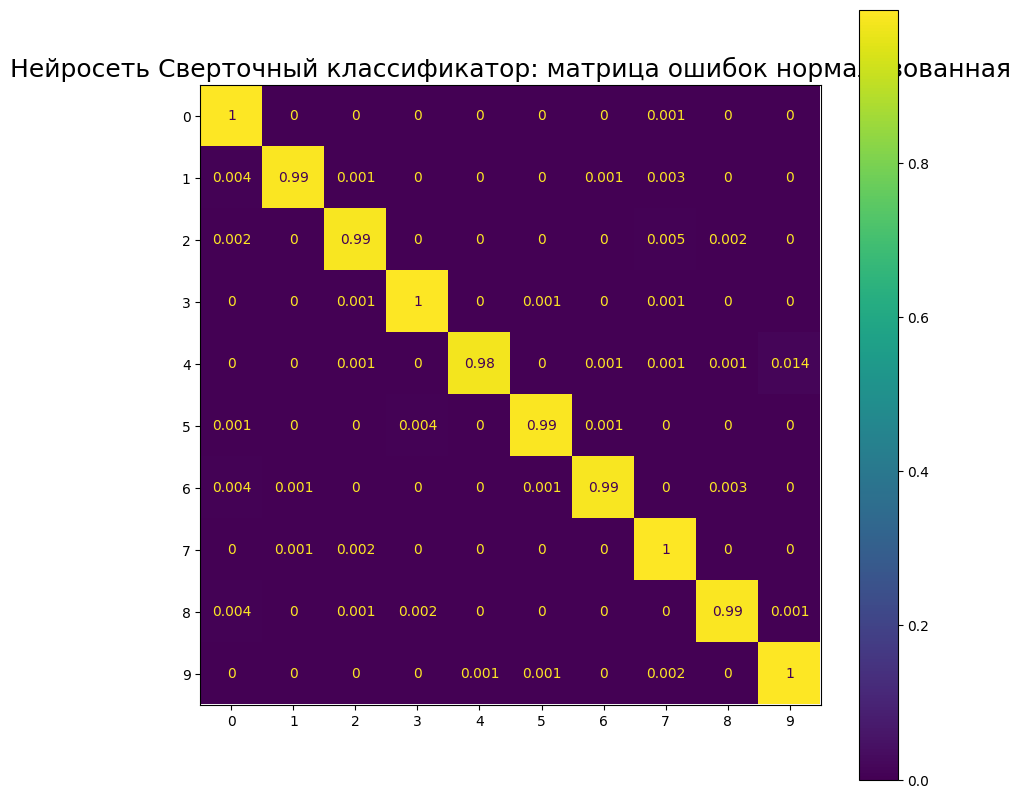

In [ ]:
compile_train_eval_model(model,
                         x_train,
                         y_train,
                         x_test,
                         y_test,
                         class_labels=10,
                         title='Сверточный классификатор')